In [1]:
!pip install torch torchvision albumentations

In [2]:
!git clone https://github.com/aliabbasi2000/PIDNet.git
%cd /content/PIDNet/

Cloning into 'PIDNet'...
remote: Enumerating objects: 595, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 595 (delta 17), reused 17 (delta 8), pack-reused 558 (from 1)
Receiving objects: 100% (595/595), 246.53 MiB | 14.33 MiB/s, done.
Resolving deltas: 100% (245/245), done.
Updating files: 100% (130/130), done.
/content/PIDNet


In [3]:
!wget https://zenodo.org/record/5706578/files/Train.zip
!wget https://zenodo.org/record/5706578/files/Val.zip
!unzip Train.zip -d ./LoveDA
!unzip Val.zip -d ./LoveDA

Streaming output truncated to the last 5000 lines.
 extracting: ./LoveDA/Train/Urban/images_png/2025.png  
 extracting: ./LoveDA/Train/Urban/images_png/2026.png  
 extracting: ./LoveDA/Train/Urban/images_png/2027.png  
 extracting: ./LoveDA/Train/Urban/images_png/2028.png  
 extracting: ./LoveDA/Train/Urban/images_png/2029.png  
 extracting: ./LoveDA/Train/Urban/images_png/2030.png  
  inflating: ./LoveDA/Train/Urban/images_png/2031.png  
 extracting: ./LoveDA/Train/Urban/images_png/2032.png  
 extracting: ./LoveDA/Train/Urban/images_png/2033.png  
  inflating: ./LoveDA/Train/Urban/images_png/2034.png  
  inflating: ./LoveDA/Train/Urban/images_png/2035.png  
 extracting: ./LoveDA/Train/Urban/images_png/2036.png  
 extracting: ./LoveDA/Train/Urban/images_png/2037.png  
 extracting: ./LoveDA/Train/Urban/images_png/2038.png  
 extracting: ./LoveDA/Train/Urban/images_png/2039.png  
 extracting: ./LoveDA/Train/Urban/images_png/2040.png  
 extracting: ./LoveDA/Train/Urban/images_png/2041.png

In [4]:
!wget --content-disposition "https://drive.usercontent.google.com/u/0/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download"
!mv PIDNet_S_ImageNet.pth.tar /content/PIDNet/pretrained_models/imagenet

--2025-01-29 12:05:31--  https://drive.usercontent.google.com/u/0/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.96.132, 2a00:1450:4013:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.96.132|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.usercontent.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download [following]
--2025-01-29 12:05:31--  https://drive.usercontent.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download
Reusing existing connection to drive.usercontent.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download [following]
--2025-01-29 12:05:31--  https://drive.usercontent.google.com/download?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download
Reusing exi

In [5]:
import os
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from albumentations import Compose, Normalize, Resize
from albumentations.pytorch import ToTensorV2
import cv2
import torch

class LoveDADataset(Dataset):
    def __init__(self, root, split='train', region='urban', transform=None):
        self.root = root
        self.split = split
        self.region = region
        self.image_dir = os.path.join(root, split, region, 'images_png')
        self.mask_dir = os.path.join(root, split, region, 'masks_png')
        self.images = sorted(os.listdir(self.image_dir))
        self.masks = sorted(os.listdir(self.mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      image_path = os.path.join(self.image_dir, self.images[idx])
      mask_path = os.path.join(self.mask_dir, self.masks[idx])

      # Load the image and mask
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

      # Convert mask to tensor and shift labels
      mask = np.array(mask, dtype=np.int64) - 1  # Shift labels to range [0, 6]
      mask = np.clip(mask, 0, 7 - 1)  # Ensure no negative values

      # Apply transformations if specified
      if self.transform:
          augmented = self.transform(image=image, mask=mask)
          image = augmented["image"]
          mask = augmented["mask"]

      # Convert to PyTorch tensors
      image = image.clone().detach().float()  # HWC to CHW
      mask = mask.clone().detach().long()

      return image, mask


class StylizedLoveDADataset(Dataset):
    def __init__(self, root, split='train', region='urban', transform=None, cyclegan=None):
        super().__init__()
        self.root = root
        self.split = split
        self.region = region
        self.image_dir = os.path.join(root, split, region, 'images_png')
        self.mask_dir = os.path.join(root, split, region, 'masks_png')
        self.images = sorted(os.listdir(self.image_dir))
        self.masks = sorted(os.listdir(self.mask_dir))
        self.transform = transform
        self.cyclegan = cyclegan

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        # Load the image and mask
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Convert mask to tensor and shift labels
        mask = np.array(mask, dtype=np.int64) - 1
        mask = np.clip(mask, 0, 6)  # Assuming 7 classes (0-6)

        # Apply transformations if specified
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # Apply style transfer if cyclegan is provided
        if self.cyclegan is not None:
            image = image.unsqueeze(0)  # Add batch dimension
            image = self.cyclegan.transform_image(image)
            image = image.squeeze(0)  # Remove batch dimension

        return image, mask

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
import torch
import torch.nn as nn
import itertools
from torch.utils.data import Dataset

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_channels=3, output_channels=3, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_channels, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_channels, 7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(input_channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)

class CycleGAN:
    def __init__(self, device):
        self.device = device

        # Initialize generators and discriminators
        self.G_AB = Generator().to(device)  # Urban to Rural
        self.G_BA = Generator().to(device)  # Rural to Urban
        self.D_A = Discriminator().to(device)  # Urban discriminator
        self.D_B = Discriminator().to(device)  # Rural discriminator

        # Initialize optimizers
        self.optimizer_G = torch.optim.Adam(
            itertools.chain(self.G_AB.parameters(), self.G_BA.parameters()),
            lr=0.0002, betas=(0.5, 0.999)
        )
        self.optimizer_D = torch.optim.Adam(
            itertools.chain(self.D_A.parameters(), self.D_B.parameters()),
            lr=0.0002, betas=(0.5, 0.999)
        )

        # Initialize loss functions
        self.criterion_GAN = nn.MSELoss()
        self.criterion_cycle = nn.L1Loss()
        self.criterion_identity = nn.L1Loss()

    def train_step(self, real_A, real_B):
        # Set model input
        real_A = real_A.to(self.device)
        real_B = real_B.to(self.device)

        # Generators AB and BA
        self.optimizer_G.zero_grad()

        # Identity loss
        loss_id_A = self.criterion_identity(self.G_BA(real_A), real_A)
        loss_id_B = self.criterion_identity(self.G_AB(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) * 5.0

        # GAN loss
        fake_B = self.G_AB(real_A)
        pred_fake = self.D_B(fake_B)
        loss_GAN_AB = self.criterion_GAN(pred_fake, torch.ones_like(pred_fake))

        fake_A = self.G_BA(real_B)
        pred_fake = self.D_A(fake_A)
        loss_GAN_BA = self.criterion_GAN(pred_fake, torch.ones_like(pred_fake))

        # Cycle loss
        recov_A = self.G_BA(fake_B)
        loss_cycle_A = self.criterion_cycle(recov_A, real_A) * 10.0

        recov_B = self.G_AB(fake_A)
        loss_cycle_B = self.criterion_cycle(recov_B, real_B) * 10.0

        # Total generator loss
        loss_G = loss_identity + loss_GAN_AB + loss_GAN_BA + loss_cycle_A + loss_cycle_B
        loss_G.backward()
        self.optimizer_G.step()

        # Discriminator A
        self.optimizer_D.zero_grad()
        pred_real = self.D_A(real_A)
        loss_D_real = self.criterion_GAN(pred_real, torch.ones_like(pred_real))

        fake_A = fake_A.detach()
        pred_fake = self.D_A(fake_A)
        loss_D_fake = self.criterion_GAN(pred_fake, torch.zeros_like(pred_fake))

        loss_D_A = (loss_D_real + loss_D_fake) * 0.5

        # Discriminator B
        pred_real = self.D_B(real_B)
        loss_D_real = self.criterion_GAN(pred_real, torch.ones_like(pred_real))

        fake_B = fake_B.detach()
        pred_fake = self.D_B(fake_B)
        loss_D_fake = self.criterion_GAN(pred_fake, torch.zeros_like(pred_fake))

        loss_D_B = (loss_D_real + loss_D_fake) * 0.5

        # Total discriminator loss
        loss_D = (loss_D_A + loss_D_B)
        loss_D.backward()
        self.optimizer_D.step()

        return {
            'loss_G': loss_G.item(),
            'loss_D': loss_D.item()
        }

    def transform_image(self, image):
        self.G_AB.eval()
        with torch.no_grad():
            transformed = self.G_AB(image.to(self.device))
        self.G_AB.train()
        return transformed

In [8]:
from torch.utils.data import DataLoader
from albumentations import Compose, HorizontalFlip, RandomRotate90, Resize, Normalize
from torchvision.transforms import ToTensor
from torchvision import transforms
from albumentations.pytorch import ToTensorV2

train_transform = Compose([
    Resize(512, 512),  # Resize both image and mask
    #####    AUGMENTATION HERE      #######
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()  # Convert to PyTorch tensors
])

# Define transforms for the evaluation phase

eval_transform = Compose([
    Resize(512, 512),  # Resize to match the input size of the model
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()  # Convert to PyTorch tensors
])

# Define dataset paths
data_root = '/content/PIDNet/LoveDA'

# Create dataloaders for unpaired images
train_urban = LoveDADataset(root=data_root, split='Train', region='Urban', transform=train_transform)
train_rural = LoveDADataset(root=data_root, split='Train', region='Rural', transform=train_transform)

urban_loader = DataLoader(train_urban, batch_size=1, shuffle=True)
rural_loader = DataLoader(train_rural, batch_size=1, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


import os
import torch

def save_checkpoint(model, epoch, losses, checkpoint_dir):
    """
    Save CycleGAN model checkpoint.

    Args:
        model: CycleGAN model instance
        epoch: Current epoch number
        losses: Dictionary of current losses
        checkpoint_dir: Directory to save checkpoints
    """
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    checkpoint = {
        'epoch': epoch,
        'G_AB_state_dict': model.G_AB.state_dict(),
        'G_BA_state_dict': model.G_BA.state_dict(),
        'D_A_state_dict': model.D_A.state_dict(),
        'D_B_state_dict': model.D_B.state_dict(),
        'optimizer_G': model.optimizer_G.state_dict(),
        'optimizer_D': model.optimizer_D.state_dict(),
        'losses': losses
    }

    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
    torch.save(checkpoint, checkpoint_path)

    # Save latest checkpoint separately for easy loading
    latest_path = os.path.join(checkpoint_dir, 'latest.pth')
    torch.save(checkpoint, latest_path)
    print(f"Checkpoint saved: {checkpoint_path}")

def load_checkpoint(model, checkpoint_path):
    """
    Load CycleGAN checkpoint.

    Args:
        model: CycleGAN model instance
        checkpoint_path: Path to checkpoint file

    Returns:
        epoch: Epoch number from checkpoint
        losses: Dictionary of losses from checkpoint
    """
    if not os.path.exists(checkpoint_path):
        print(f"No checkpoint found at {checkpoint_path}")
        return 0, None

    checkpoint = torch.load(checkpoint_path, map_location=model.device)

    # Load model states
    model.G_AB.load_state_dict(checkpoint['G_AB_state_dict'])
    model.G_BA.load_state_dict(checkpoint['G_BA_state_dict'])
    model.D_A.load_state_dict(checkpoint['D_A_state_dict'])
    model.D_B.load_state_dict(checkpoint['D_B_state_dict'])

    # Load optimizer states
    model.optimizer_G.load_state_dict(checkpoint['optimizer_G'])
    model.optimizer_D.load_state_dict(checkpoint['optimizer_D'])

    print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
    return checkpoint['epoch'], checkpoint['losses']


# Initialize CycleGAN
cyclegan = CycleGAN(device)

# Initialize checkpoint directory
checkpoint_dir = './checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Load latest checkpoint if exists
start_epoch = 0
#latest_checkpoint = os.path.join(checkpoint_dir, 'latest.pth')
latest_checkpoint ='/content/PIDNet/checkpoints/checkpoint_epoch_10.pth'
if os.path.exists(latest_checkpoint):
    start_epoch, losses = load_checkpoint(cyclegan, latest_checkpoint)
    print(f"Checkpoint loaded")

# Training loop
num_epochs = 10
for epoch in range(start_epoch, num_epochs):
    epoch_losses = []
    for urban_batch, rural_batch in zip(urban_loader, rural_loader):
        urban_imgs, _ = urban_batch
        rural_imgs, _ = rural_batch

        losses = cyclegan.train_step(urban_imgs, rural_imgs)
        epoch_losses.append(losses)
        print(f"Epoch [{epoch+1}/{num_epochs}] Losses: {losses}")

    # Calculate average losses for the epoch
    avg_losses = {k: sum(d[k] for d in epoch_losses) / len(epoch_losses)
                 for k in epoch_losses[0].keys()}

    save_checkpoint(cyclegan, epoch + 1, avg_losses, checkpoint_dir)








<ipython-input-8-56424b814ee8>:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=model.device)


Loaded checkpoint from epoch 10
Checkpoint loaded


In [15]:
# Create stylized dataset
train_dataset = StylizedLoveDADataset(
    root=data_root,
    split='Train',
    region='Urban',
    transform=train_transform,
    cyclegan=cyclegan
)

val_dataset = LoveDADataset(
    root=data_root,
    split='Val',
    region='Rural',
    transform=eval_transform
)
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,  # Set to 0 to avoid multiprocessing issues
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=0,  # Set to 0 to avoid multiprocessing issues
)


In [16]:
import torch
from models.pidnet import get_seg_model
import yaml

import gc





## get_pred ------------------------------------
#model = get_pred_model('pidnet_s', num_classes=7)

## get_seg ------------------------------------
# Convert the dictionary to a DotDict
class DotDict(dict):
    """A dictionary that supports attribute-style access."""
    def __getattr__(self, name):
        value = self.get(name)
        if isinstance(value, dict):
            return DotDict(value)
        return value

    def __setattr__(self, name, value):
        self[name] = value

# Load the YAML configuration
with open('/content/PIDNet/configs/loveda/pidnet_small_loveda.yaml', 'r') as f:
    cfg_dict = yaml.safe_load(f)

# Convert to DotDict for attribute-style access
cfg = DotDict(cfg_dict)

imgnet = 'imagenet' in cfg.MODEL.PRETRAINED

model = get_seg_model(cfg, imgnet_pretrained=imgnet)


model = model.to(device)




In [17]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss(ignore_index=-1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

In [12]:
!pip install torchinfo

In [18]:
import torch.nn.functional as F
from torchinfo import summary
import time
import numpy as np

def calculate_iou(predictions, ground_truth, num_classes):
    classwise_iou = []
    for cls in range(num_classes):
        tp = ((predictions == cls) & (ground_truth == cls)).sum().item()
        fp = ((predictions == cls) & (ground_truth != cls)).sum().item()
        fn = ((predictions != cls) & (ground_truth == cls)).sum().item()

        if tp + fp + fn == 0:
            iou = float('nan')
        else:
            iou = tp / (tp + fp + fn)
        classwise_iou.append(iou)

    return classwise_iou

# Training
model.train()
num_epochs = 20
num_classes = 7
class_labels = ["background", "building", "road", "water", "barren", "forest", "agriculture"]
epoch_train_miou = []  # To store training mIoU per epoch
epoch_val_miou = []    # To store validation mIoU per epoch
epoch_train_loss = []  # To store training loss per epoch
epoch_val_loss = []    # To store validation loss per epoch

final_avg_latency = 0.0
final_flops = 0.0
final_params = 0

for epoch in range(num_epochs):
    # Training phase
    train_loss = 0.0
    total_latency = 0.0
    train_classwise_iou = np.zeros(num_classes)
    num_batches = 0

    model.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        start_time = time.time()
        outputs = model(images)
        latency = time.time() - start_time
        total_latency += latency

        outputs = outputs[0]
        masks = F.interpolate(masks.unsqueeze(1).float(), size=(outputs.shape[2], outputs.shape[3]), mode='nearest').squeeze(1).long()
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        batch_iou = calculate_iou(preds, masks, num_classes)
        train_classwise_iou += np.nan_to_num(batch_iou)
        num_batches += 1

    train_loss /= len(train_loader)
    avg_latency = total_latency / len(train_loader)
    mean_classwise_iou = train_classwise_iou / num_batches
    train_mean_iou = np.nanmean(mean_classwise_iou)
    epoch_train_miou.append(train_mean_iou)
    epoch_train_loss.append(train_loss)

    if epoch == num_epochs - 1:  # Save latency, FLOPs, and Params only for the final epoch
        final_avg_latency = avg_latency
        flops_summary = summary(model, input_size=(1, *images.shape[1:]), verbose=0)
        final_flops = flops_summary.total_mult_adds
        final_params = flops_summary.total_params

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training mIoU: {train_mean_iou:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_classwise_iou = np.zeros(num_classes)
    num_batches = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = outputs[0]
            masks = F.interpolate(masks.unsqueeze(1).float(), size=(outputs.shape[2], outputs.shape[3]), mode='nearest').squeeze(1).long()
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            batch_iou = calculate_iou(preds, masks, num_classes)
            val_classwise_iou += np.nan_to_num(batch_iou)
            num_batches += 1

    val_loss /= len(val_loader)
    mean_classwise_iou = val_classwise_iou / num_batches
    val_mean_iou = np.nanmean(mean_classwise_iou)
    epoch_val_miou.append(val_mean_iou)
    epoch_val_loss.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation mIoU: {val_mean_iou:.4f}")

# Print final results
print(f"\nFinal Average Latency: {final_avg_latency:.4f} seconds")
print(f"Final FLOPs: {final_flops:.2f}")
print(f"Final Params: {final_params}")

print("Class-wise IoU:")
for cls, label in enumerate(class_labels):
    print(f"  {label}: {mean_classwise_iou[cls]:.4f}")


Epoch 1/20, Training Loss: 2.0969, Training mIoU: 0.1679
Epoch 1/20, Validation Loss: 2.6990, Validation mIoU: 0.1150
Epoch 2/20, Training Loss: 1.1258, Training mIoU: 0.2581
Epoch 2/20, Validation Loss: 2.6296, Validation mIoU: 0.1251
Epoch 3/20, Training Loss: 0.9976, Training mIoU: 0.3070
Epoch 3/20, Validation Loss: 2.4962, Validation mIoU: 0.1409
Epoch 4/20, Training Loss: 0.9283, Training mIoU: 0.3414
Epoch 4/20, Validation Loss: 2.5099, Validation mIoU: 0.1497
Epoch 5/20, Training Loss: 0.8854, Training mIoU: 0.3609
Epoch 5/20, Validation Loss: 2.6440, Validation mIoU: 0.1737
Epoch 6/20, Training Loss: 0.8440, Training mIoU: 0.3818
Epoch 6/20, Validation Loss: 2.4194, Validation mIoU: 0.1655
Epoch 7/20, Training Loss: 0.8154, Training mIoU: 0.3990
Epoch 7/20, Validation Loss: 2.5168, Validation mIoU: 0.1980
Epoch 8/20, Training Loss: 0.7845, Training mIoU: 0.4121
Epoch 8/20, Validation Loss: 2.4812, Validation mIoU: 0.1999
Epoch 9/20, Training Loss: 0.7699, Training mIoU: 0.4186

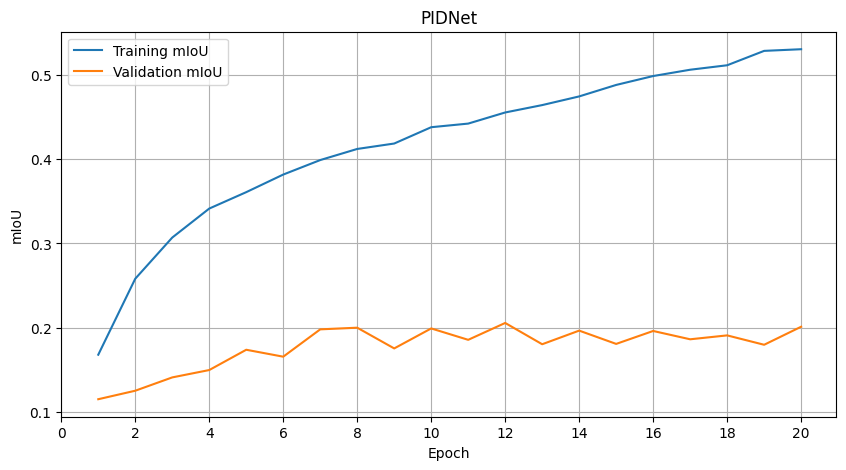

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_train_miou, label='Training mIoU')
plt.plot(range(1, num_epochs + 1), epoch_val_miou, label='Validation mIoU')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('PIDNet')
plt.legend()
plt.grid(True)
plt.xticks(range(0, num_epochs + 2, 2))
plt.show()



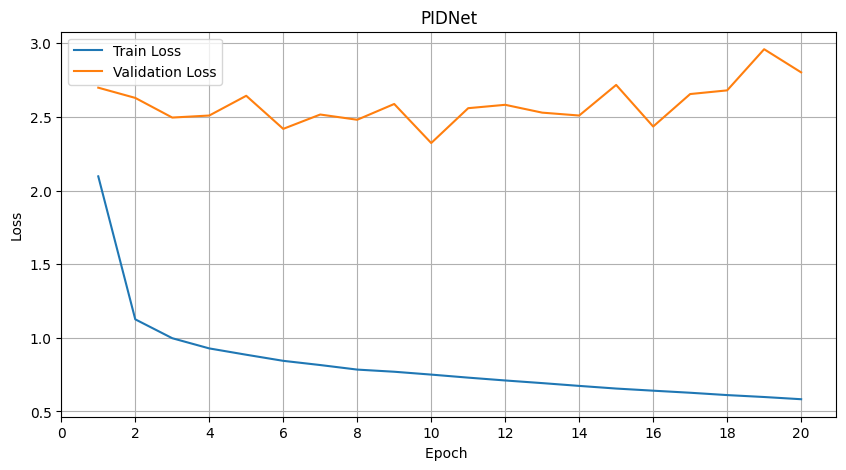

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_train_loss, label="Train Loss")
plt.plot(range(1, num_epochs + 1), epoch_val_loss, label="Validation Loss")
plt.xlabel("Epoch ")
plt.ylabel("Loss")
plt.title("PIDNet")
plt.legend()
plt.grid(True)
plt.xticks(range(0, num_epochs + 2, 2))
plt.show()

In [21]:
# Download the Test Image
!mkdir -p LoveDA/Test/Rural

!wget https://github.com/aliabbasi2000/Real-time-Domain-Adaptation-in-Semantic-Segmentation/blob/280a73361b252434aa65f9602b4b51714d092015/data/LoveDA/Test/Rural/4196.png -O LoveDA/Test/Rural/4196.png


--2025-01-29 13:40:25--  https://github.com/aliabbasi2000/Real-time-Domain-Adaptation-in-Semantic-Segmentation/blob/280a73361b252434aa65f9602b4b51714d092015/data/LoveDA/Test/Rural/4196.png
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-01-29 13:40:26 ERROR 404: Not Found.



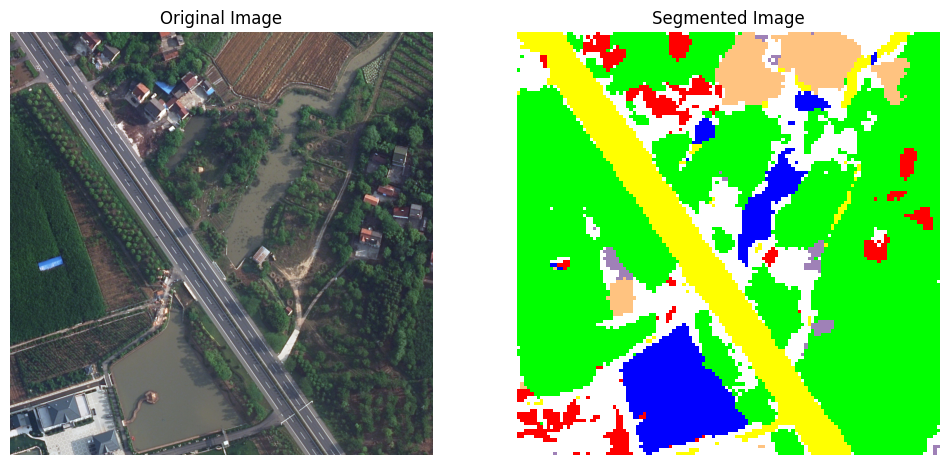

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Define label colors (R, G, B) for each class
class_labels = ["background", "building", "road", "water", "barren", "forest", "agriculture"]
label_colors = {
    "background": (255, 255, 255),        # White
    "building": (255, 0, 0),             # Red
    "road": (255, 255, 0),               # Yellow
    "water": (0, 0, 255),                # Blue
    "barren": (159, 129, 183),           # Purple
    "forest": (0, 255, 0),               # Green
    "agriculture": (255, 195, 128)       # Peach
}

# Load a single image for segmentation
image_path = "/content/PIDNet/LoveDA/Test/Rural"
image_files = [f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f)) and not f.startswith('.')]
image_name = image_files[0]
image = Image.open(os.path.join(image_path, image_name)).convert('RGB')



# Preprocess the image (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_image = transform(image).unsqueeze(0).to(device)

# Perform inference with the model
model.eval()
with torch.no_grad():
    output = model(input_image)  # Shape: (1, num_classes, H, W)
    output = output[0]  # Remove auxiliary outputs if present
    preds = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # Shape: (H, W)

# Create a segmentation map
segmentation_map = np.zeros((preds.shape[0], preds.shape[1], 3), dtype=np.uint8)

for label_index, label_name in enumerate(class_labels):
    color = label_colors[label_name]
    segmentation_map[preds == label_index] = color

# Visualize the original image and segmentation map
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(segmentation_map)
plt.title("Segmented Image")
plt.axis("off")

plt.show()